In [1]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import math
import pandas as pd 
from sklearn.ensemble import IsolationForest
from sklearn import metrics 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from collections import Counter
from inspect import signature 
import scipy
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read full data in this notebook only

In [2]:
df = pd.read_csv("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/data/features_5m_12h.csv")

In [3]:
labels = df["Label"].values
timestamp = df["TimeStamp"].values
df.drop(["TimeStamp", "Label"], axis = 1, inplace = True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.values, labels, test_size = 0.40,
                                                    shuffle = False, random_state = 42)

In [8]:
model = IsolationForest(random_state = 42)
model.fit(X_train)

IsolationForest(random_state=42)

In [9]:
y_hat = model.predict(X_test)
print("Baseline performance: {perf}".format(perf = metrics.f1_score(y_test, y_hat, average = "micro")))

Baseline performance: 0.053747065169109716


In [10]:
# how many faults did the baseline model guess ? 
print(Counter(y_hat))

Counter({1: 25601, -1: 5917})


### Hyperparameter Tuning

In [11]:
param_grid = {"n_estimators": [100],
             "contamination": [0.025,0.05,0.1]}
cv = StratifiedKFold(shuffle = False)
gscv = GridSearchCV(model, param_grid, cv = cv, refit = True, scoring = "f1_micro", verbose = 1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=IsolationForest(random_state=42),
             param_grid={'contamination': [0.025, 0.05, 0.1],
                         'n_estimators': [100]},
             scoring='f1_micro', verbose=1)

In [12]:
print(gscv.best_params_)
y_hat = gscv.best_estimator_.predict(X_test)
# get recall micro after best estimator is refit
print("GridSearchCV F-1 Score: {perf}".format(perf = metrics.f1_score(y_test, y_hat, average = "micro")))

{'contamination': 0.025, 'n_estimators': 100}
GridSearchCV F-1 Score: 0.07573450092010914


In [13]:
scores_df = pd.DataFrame({"yhat" : y_hat})
scores_df.head(3)

,yhat
0,1
1,1
2,1


In [14]:
# iForest returns -1 for anomaly
# iForest returns 1 for normal
scores_df.yhat = scores_df.yhat.transform(lambda yhat: 0 if yhat == 1 else 1)

In [15]:
scores_df["y_true"] = y_test.astype("int64")
scores_df["squared_error"] = np.power(scores_df.y_true - scores_df.yhat, 2).astype("float64")
scores_df.head(3)

,yhat,y_true,squared_error
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0


In [16]:
threshold = np.mean(scores_df.squared_error)
print(f"Threshold: {round(threshold,3)}")

Threshold: 0.124


### Model Mean Squared Error

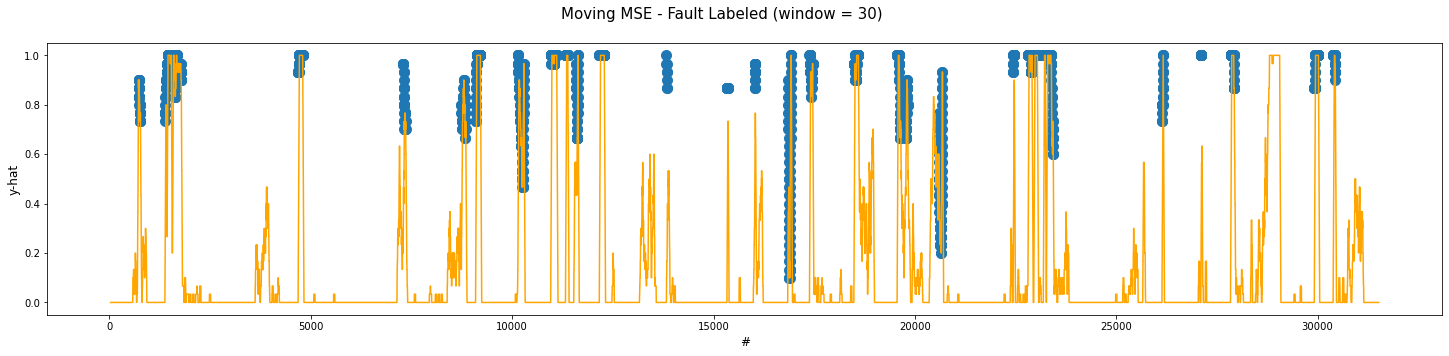

In [17]:
window = 30 # 2H 30M 
display_scatter = True 
show_threshold = False

fig, ax = plt.subplots(figsize = (25,5))
scores_df.squared_error.rolling(window = window).mean()[window:].plot(color = "orange")
fault_index = scores_df.squared_error[scores_df.y_true == 1].rolling(window = window).mean()[window:].index
faults = scores_df.squared_error[scores_df.y_true == 1].rolling(window = window).mean()[window:]
if display_scatter:
    plt.scatter(fault_index, faults, s = 100)
else:
    [plt.axvline(f, linewidth = 0.09, color = "blue") for f in fault_index]
if show_threshold:
    plt.hlines(threshold, ax.get_xlim()[0],ax.get_xlim()[1], colors = "red", linestyles = "dashed")
plt.suptitle("Moving MSE - Fault Labeled (window = {w})".format(w = window), fontsize = 15)
plt.xlabel("#", fontsize = 12)
plt.ylabel("y-hat", fontsize = 12)
fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/baseline/mse_30.jpeg")
plt.show()

### Model Prediction 

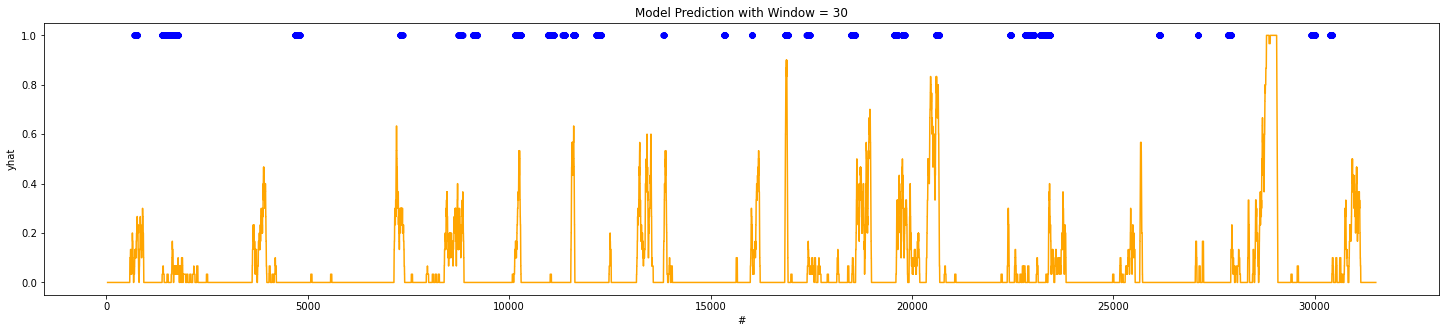

In [18]:
faults = scores_df.y_true[scores_df.y_true == 1]
non_faults = scores_df.y_true[scores_df.y_true == 0]
pred = scores_df.yhat.rolling(window = window).mean()[window:]
pred.plot(figsize = (25,5), color = "orange")
plt.scatter(x = np.where(scores_df.y_true == 1), y = faults, s = 25, color = "b")
plt.title("Model Prediction with Window = " + str(window))
plt.xlabel("#")
plt.ylabel("yhat")
fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/baseline/pred_30.jpeg")
plt.show() 

In [19]:
pd.DataFrame(pred).describe()

,yhat
count,31488.000000
mean,0.056879
std,0.148091
min,0.000000
25%,0.000000
50%,0.000000
75%,0.033333
max,1.000000


Threshold: 0.05687881097560827


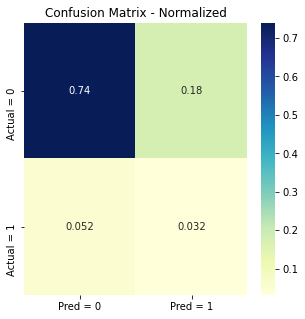

recall (sensitivity): 37.93%
specificity: 80.71%
precision (PPV): 15.36%
NPV: 93.37%
F-1: 21.86%


In [22]:
def extract_metrics(pred, faults, non_faults):
    t = np.mean(pred)
    print("Threshold: {}".format(t))
    
    f = faults.index
    nf = non_faults.index
    npred = (pred[pred < t]).index 
    ppred = (pred[pred > t]).index
    
    # for confusion matrix computation 
    pred_set = set(ppred)
    npred_set = set(npred)
    total_pred_set = set(pred)
    fault_set = set(f)
    nfault_set = set(nf)
    
    tp = len(list(fault_set.intersection(pred_set))) / len(list(total_pred_set))
    tn = len(list(nfault_set.intersection(npred_set))) / len(list(total_pred_set))
    fp = len(list(pred_set.difference(fault_set))) / len(list(total_pred_set))
    fn = len(list(npred_set.difference(nfault_set))) / len(list(total_pred_set))
    
    return tp, tn, fp, fn

tp, tn, fp, fn = extract_metrics(pred, faults, non_faults)
    
def normalizer(tp, tn, fp, fn):
    total = tp + tn + fp + fn
    metric_list = [tp, tn, fp, fn]
    normalized = [m / total for m in metric_list]
    return normalized[0], normalized[1], normalized[2], normalized[3]

# normalize
tp_n, tn_n, fp_n, fn_n = normalizer(tp, tn, fp, fn)

def plot_confusion_matrix_normalized(tp_n, tn_n, fp_n, fn_n):
    confusion_matrix = np.zeros((2,2))
    confusion_matrix[0][0] = tn_n
    confusion_matrix[0][1] = fp_n
    confusion_matrix[1][0] = fn_n
    confusion_matrix[1][1] = tp_n
    xlabel = ["Pred = 0", "Pred = 1"]
    ylabel = ["Actual = 0", "Actual = 1"]
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(confusion_matrix, cmap = "YlGnBu", annot = True, fmt = ".2g", xticklabels = xlabel, yticklabels = ylabel, ax = ax)
    plt.title("Confusion Matrix - Normalized")
    fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/baseline/conf_matrix.jpeg")
    plt.show()


def define_metrics(tp_n, tn_n, fp_n, fn_n):
    metrics = {"recall (sensitivity):": 0.0, "specificity:": 0.0, 
               "precision (PPV):": 0.0, "NPV:": 0.0,
               "F-1:": 0.0
              }
    metrics["recall (sensitivity):"] = tp_n / (fn_n + tp_n)
    metrics["specificity:"] = tn_n / (tn_n + fp_n)
    metrics["precision (PPV):"] = tp_n / (tp_n + fp_n) 
    metrics["NPV:"] = tn_n / (fn_n + tn_n)
    metrics["F-1:"] = 2 * ((metrics["recall (sensitivity):"] * metrics["precision (PPV):"]) / (metrics["recall (sensitivity):"] + 
                                                                                            metrics["precision (PPV):"]))
    # scale to 100
    for key, value in metrics.items():
        metrics[key] = round(metrics[key] * 100, 2) 
    return metrics

plot_confusion_matrix_normalized(tp_n, tn_n, fp_n, fn_n)

m  = define_metrics(tp_n, tn_n, fp_n, fn_n)
with open("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/baseline/metrics.txt", "w") as f:
    for key, value in m.items():
        f.write(key + " " + str(value) + "%\n")
    f.close()
for key, value in m.items():
    print(key, str(value) + "%")

### Upsampling - 5M

In [23]:
# upsample raw data by 5 minutes 
upsample_df = df.copy()
upsample_df["labels"] = labels
upsample_df["freq"] = pd.to_datetime(timestamp)
upsample_df.freq.head(5)

0   2018-11-02 15:15:00
1   2018-11-02 15:30:00
2   2018-11-02 15:35:00
3   2018-11-02 15:40:00
4   2018-11-02 15:45:00
Name: freq, dtype: datetime64[ns]

In [24]:
upsample_df = upsample_df.pivot_table(index = "freq", values = upsample_df.iloc[::])

In [25]:
upsample_df = upsample_df.resample("5T").mean().ffill()
upsample_df.isnull().sum()

ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_x      0
ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_x.1    0
ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_y      0
ALM_Ai_Mainau1CleaningAirPress_B12591_PDP_y.1    0
ALM_Ai_Mainau2CleaningAirPress_B12593_PDP_x      0
                                                ..
ALM_Mainau2_HDownVac_Scale_PDP_x                 0
ALM_Mainau2_HDownVac_Scale_PDP_x.1               0
ALM_Mainau2_HDownVac_Scale_PDP_y                 0
ALM_Mainau2_HDownVac_Scale_PDP_y.1               0
labels                                           0
Length: 73, dtype: int64

In [26]:
# train the same model with upsampled data
X_train, X_test, y_train, y_test = train_test_split(upsample_df, upsample_df.labels, test_size = 0.4,
                                                    shuffle = False, random_state = 84)
assert(X_train.shape[0] == y_train.shape[0])

In [27]:
model = IsolationForest(random_state = 42)
model.fit(X_train)

IsolationForest(random_state=42)

In [28]:
param_grid = {"n_estimators": [100],
             "contamination": [0.025,0.05,0.1]}
cv = StratifiedKFold(shuffle = False)
gscv = GridSearchCV(model, param_grid, cv = cv, refit = True, scoring = "f1_micro", verbose = 1)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=IsolationForest(random_state=42),
             param_grid={'contamination': [0.025, 0.05, 0.1],
                         'n_estimators': [100]},
             scoring='f1_micro', verbose=1)

In [29]:
print(gscv.best_params_)
y_hat = gscv.best_estimator_.predict(X_test)
# get recall micro after best estimator is refit to the upsampled model
print("GridSearchCV F-1 Score: {perf}".format(perf = metrics.f1_score(y_test, y_hat, average = "micro")))

{'contamination': 0.025, 'n_estimators': 100}
GridSearchCV F-1 Score: 0.08146934283868806


In [30]:
scores_df = pd.DataFrame({"yhat" : y_hat})
scores_df.head(3)

,yhat
0,1
1,1
2,1


In [31]:
# iForest returns -1 for anomaly
# iForest returns 1 for normal
scores_df.yhat = scores_df.yhat.transform(lambda yhat: 0 if yhat == 1 else 1)

In [32]:
scores_df["y_true"] = y_test.astype("int64").values
scores_df["squared_error"] = np.power(scores_df.y_true - scores_df.yhat, 2).astype("float64")
scores_df.head(3)

,yhat,y_true,squared_error
0,0,0,0.0
1,0,0,0.0
2,0,0,0.0


In [33]:
threshold = np.mean(scores_df.squared_error)
print(f"Threshold: {round(threshold,3)}")

Threshold: 0.146


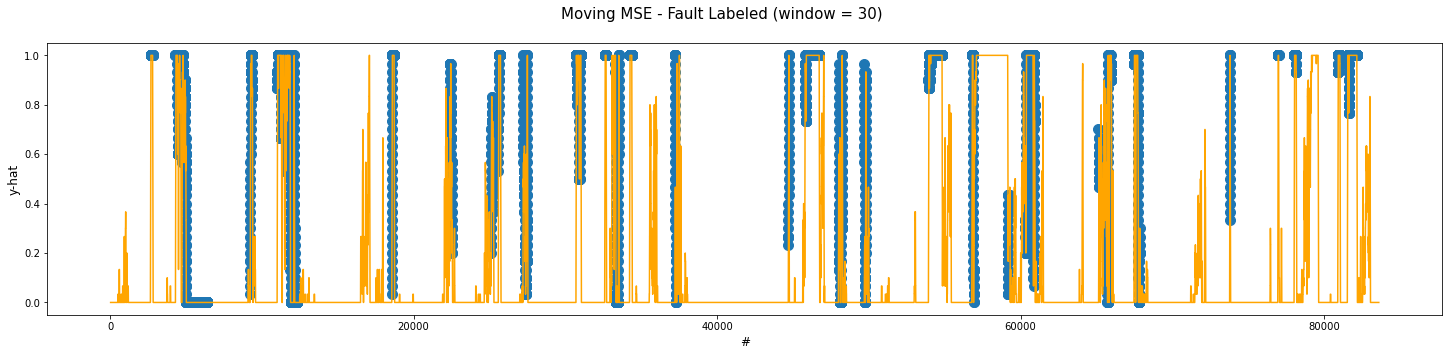

In [34]:
window = 30 # 2H 30M 
display_scatter = True 
show_threshold = False

fig, ax = plt.subplots(figsize = (25,5))
scores_df.squared_error.rolling(window = window).mean()[window:].plot(color = "orange")
fault_index = scores_df.squared_error[scores_df.y_true == 1].rolling(window = window).mean()[window:].index
faults = scores_df.squared_error[scores_df.y_true == 1].rolling(window = window).mean()[window:]
if display_scatter:
    plt.scatter(fault_index, faults, s = 100)
else:
    [plt.axvline(f, linewidth = 0.09, color = "blue") for f in fault_index]
if show_threshold:
    plt.hlines(threshold, ax.get_xlim()[0],ax.get_xlim()[1], colors = "red", linestyles = "dashed")
plt.suptitle("Moving MSE - Fault Labeled (window = {w})".format(w = window), fontsize = 15)
plt.xlabel("#", fontsize = 12)
plt.ylabel("y-hat", fontsize = 12)
fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/upsampling/upsample_mse_30.jpeg")
plt.show()

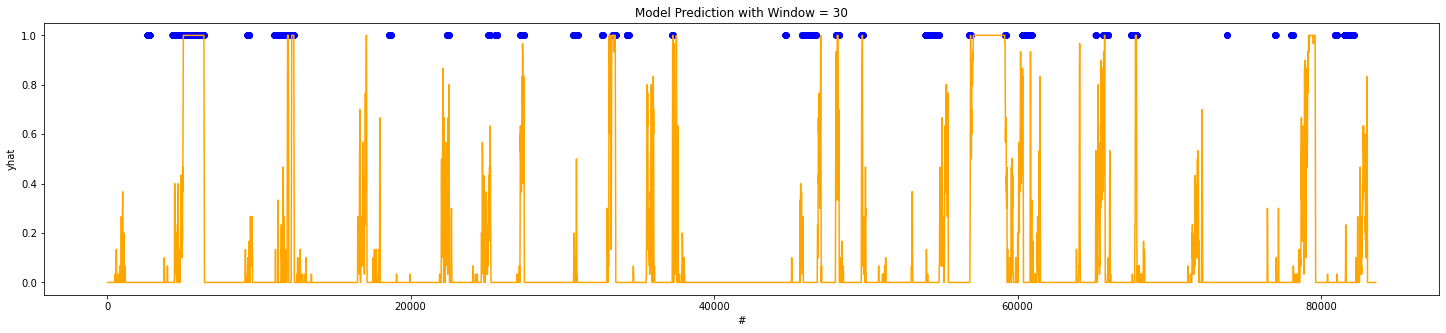

In [35]:
faults = scores_df.y_true[scores_df.y_true == 1]
non_faults = scores_df.y_true[scores_df.y_true == 0]
pred = scores_df.yhat.rolling(window = window).mean()[window:]
pred.plot(figsize = (25,5), color = "orange")
plt.scatter(x = np.where(scores_df.y_true == 1), y = faults, s = 25, color = "b")
plt.title("Model Prediction with Window = " + str(window))
plt.xlabel("#")
plt.ylabel("yhat")
fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/upsampling/upsample_pred_30.jpeg")
plt.show() 

In [36]:
pd.DataFrame(pred).describe()

,yhat
count,83572.000000
mean,0.100668
std,0.259862
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Threshold: 0.10066768774230805


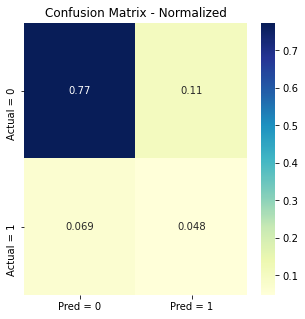

recall (sensitivity): 40.97%
specificity: 87.56%
precision (PPV): 30.41%
NPV: 91.79%
F-1: 34.91%


In [38]:
def extract_metrics(pred, faults, non_faults):
    t = np.mean(pred)
    print("Threshold: {}".format(t))
    
    f = faults.index
    nf = non_faults.index
    npred = (pred[pred < t]).index 
    ppred = (pred[pred > t]).index
    
    # for confusion matrix computation 
    pred_set = set(ppred)
    npred_set = set(npred)
    total_pred_set = set(pred)
    fault_set = set(f)
    nfault_set = set(nf)
    
    tp = len(list(fault_set.intersection(pred_set))) / len(list(total_pred_set))
    tn = len(list(nfault_set.intersection(npred_set))) / len(list(total_pred_set))
    fp = len(list(pred_set.difference(fault_set))) / len(list(total_pred_set))
    fn = len(list(npred_set.difference(nfault_set))) / len(list(total_pred_set))
    
    return tp, tn, fp, fn

tp, tn, fp, fn = extract_metrics(pred, faults, non_faults)
    
def normalizer(tp, tn, fp, fn):
    total = tp + tn + fp + fn
    metric_list = [tp, tn, fp, fn]
    normalized = [m / total for m in metric_list]
    return normalized[0], normalized[1], normalized[2], normalized[3]

# normalize
tp_n, tn_n, fp_n, fn_n = normalizer(tp, tn, fp, fn)

def plot_confusion_matrix_normalized(tp_n, tn_n, fp_n, fn_n):
    confusion_matrix = np.zeros((2,2))
    confusion_matrix[0][0] = tn_n
    confusion_matrix[0][1] = fp_n
    confusion_matrix[1][0] = fn_n
    confusion_matrix[1][1] = tp_n
    xlabel = ["Pred = 0", "Pred = 1"]
    ylabel = ["Actual = 0", "Actual = 1"]
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(confusion_matrix, cmap = "YlGnBu", annot = True, fmt = ".2g", xticklabels = xlabel, yticklabels = ylabel, ax = ax)
    plt.title("Confusion Matrix - Normalized")
    fig.savefig("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/upsampling/upsample_conf_matrix.jpeg")
    plt.show()


def define_metrics(tp_n, tn_n, fp_n, fn_n):
    metrics = {"recall (sensitivity):": 0.0, "specificity:": 0.0, 
               "precision (PPV):": 0.0, "NPV:": 0.0,
               "F-1:": 0.0
              }
    metrics["recall (sensitivity):"] = tp_n / (fn_n + tp_n)
    metrics["specificity:"] = tn_n / (tn_n + fp_n)
    metrics["precision (PPV):"] = tp_n / (tp_n + fp_n) 
    metrics["NPV:"] = tn_n / (fn_n + tn_n)
    metrics["F-1:"] = 2 * ((metrics["recall (sensitivity):"] * metrics["precision (PPV):"]) / (metrics["recall (sensitivity):"] + 
                                                                                            metrics["precision (PPV):"]))
    # scale to 100
    for key, value in metrics.items():
        metrics[key] = round(metrics[key] * 100, 2) 
    return metrics

plot_confusion_matrix_normalized(tp_n, tn_n, fp_n, fn_n)

m  = define_metrics(tp_n, tn_n, fp_n, fn_n)
with open("/Users/kaanguney.keklikci/Desktop/Sabancı/ENS 492/source/results/upsampling/upsample_metrics.txt", "w") as f:
    for key, value in m.items():
        f.write(key + " " + str(value) + "%\n")
    f.close()
for key, value in m.items():
    print(key, str(value) + "%")